## Imports

In [1]:
!pip install tqdm pydot losswise
!apt-get install -yqq graphviz graphviz-dev >> /dev/null
!pip install git+git://github.com/frenchie4111/dumbrain

  Cloning git://github.com/frenchie4111/dumbrain to /tmp/pip-req-build-j714k46k
  Running setup.py bdist_wheel for dumbrain ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-wtopgbiv/wheels/00/20/0b/d28188ed453ea54550e09277f5d9daa859ae797193b9727666
Successfully built dumbrain


In [2]:
import os
from os import path

import pydot

import keras
from keras import models, layers, losses, optimizers, preprocessing, utils, Model
import keras.backend as K
import tensorflow 

import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
import sys
from enum import Enum
import losswise
losswise.set_api_key('GM77BZUC6')
from losswise.libs import LosswiseKerasCallback

from PIL import Image

Using TensorFlow backend.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def upload( local_filename, target_filename ):
    file_to_upload = drive.CreateFile( { 'title': target_filename } )
    file_to_upload.SetContentFile( local_filename )
    file_to_upload.Upload()
    print( 'Uploaded' )

## Download Data

In [4]:
from dumbrain.lib.download import downloadAndUnzip
sonic_map_exports = "http://aiml.mikelyons.org/datasets/sonic/sonlvl_exports/Sonic%20Map%20Exports.zip"
downloadAndUnzip( sonic_map_exports, 'data/' )

18866176it [00:01, 17176035.71it/s]                             
100%|██████████| 21651129/21651129 [00:03<00:00, 5939093.81it/s]


In [5]:
!ls data/

record	roms  Sonic Map Exports


## Load Chunks

In [0]:
def loadChunks( path_to_chunks_dir, col_postfix = '_col', pri_postfix = '_pri', include_filenames=False ):
    all_chunk_files = os.listdir( path_to_chunks_dir )
    all_chunk_files.sort()

    chunk_filenames = list(
        filter(
            lambda filename: (
                col_postfix not in filename and
                pri_postfix not in filename
            ), all_chunk_files
        )
    )

    # Get one block so we know the size for our numpy arr. Assume all blocks are the same size
    sample_image = scipy.misc.imread( path.join( path_to_chunks_dir, chunk_filenames[ 0 ] ), mode='RGBA' )
    # ( samples, (image, collision map, chunk_alpha), w, h )
    new_chunks = np.zeros( ( len( chunk_filenames ), sample_image.shape[ 0 ], sample_image.shape[ 1 ], 5 ), dtype=np.uint8 )

    for i, chunk_filename in enumerate( chunk_filenames ):
        chunk_filename_with_col = path.splitext( chunk_filename )[ 0 ] + col_postfix
        col_files = list( filter( lambda file: file.startswith( chunk_filename_with_col ), all_chunk_files ) )
        col_files.sort()
        assert len( col_files ) > 0
        
        chunk_filename = path.join( path_to_chunks_dir, chunk_filename )
        col_filename = path.join( path_to_chunks_dir, col_files[ 0 ] )

        chunk_image = scipy.misc.imread( chunk_filename, mode='RGBA' )
        new_chunks[ i, :, :, 0:4 ] = chunk_image[ :, : ].astype( np.uint8 )

        col_image = scipy.misc.imread( col_filename, mode='RGBA' )
        col_image_flattened = np.logical_not( # Where not pink
            np.logical_and(
                col_image[ :, :, 0 ] == 255, 
                col_image[ :, :, 1 ] == 0, 
                col_image[ :, :, 2 ] == 255 
            ) 
        ) * 255
        new_chunks[ i, :, :, 4 ] = col_image_flattened.astype( np.uint8 )

    if include_filenames:
        return new_chunks, chunk_filenames
    return new_chunks

## Load Maps (bg&chunks)

In [8]:
maps = []

# keys
k_background = 'background'
k_chunks = 'chunks'
k_game_name = 'game_name'
k_map_name = 'map_name'
k_chunk_filenames = 'chunk_filenames'

def makeMap(
    game_name,
    map_name,
    background,
    chunks,
    chunk_filenames
):
    return {
        k_game_name: game_name,
        k_map_name: map_name,
        k_background: background,
        k_chunks: chunks,
        k_chunk_filenames: chunk_filenames
    }

makeMap( 'test', 'test', 'test', 'test', 'test' )

{'game_name': 'test',
 'map_name': 'test',
 'background': 'test',
 'chunks': 'test',
 'chunk_filenames': 'test'}

In [0]:
games_dir = 'data/Sonic Map Exports'

game_dirs = os.listdir( games_dir )

for game_dir in game_dirs:
    game_dir_full_path = path.join( games_dir, game_dir )
    game_map_dirs = os.listdir( game_dir_full_path )

    for map_dir in game_map_dirs:
        map_dir_full_path = path.join( game_dir_full_path, map_dir )
        
        background_full_path = path.join( map_dir_full_path, 'background.png' )
        assert os.path.exists( background_full_path )
        background = scipy.misc.imread( background_full_path, mode='RGBA' )

        chunk_full_path = path.join( map_dir_full_path, 'chunks' )
        assert os.path.exists( chunk_full_path )
        chunks, chunk_filenames = loadChunks( chunk_full_path, include_filenames=True )
        
        map = makeMap(
            game_name=game_dir,
            map_name=map_dir,
            background=background,
            chunks=chunks,
            chunk_filenames=chunk_filenames
        )
        maps.append( map )

24
1.png
uint8


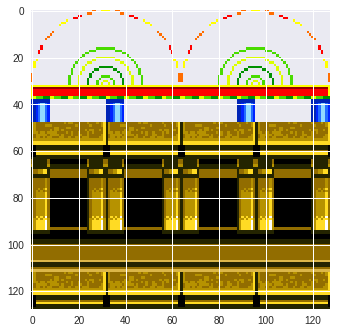

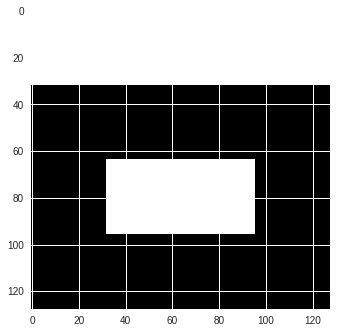

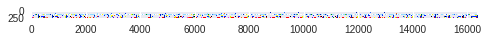

In [10]:
print( len( maps ) )

image_idx = 1 # Loop
# image_idx = np.random.randint( chunks.shape[ 0 ] )
print( chunk_filenames[ image_idx ] )

print( chunks.dtype )

plt.imshow( maps[ 0 ][ k_chunks ][ image_idx, :, :, 0:4 ] )
plt.subplots()
plt.imshow( maps[ 0 ][ k_chunks ][ image_idx, :, :, 4 ] )
plt.subplots()
plt.imshow( maps[ 0 ][ k_background ] )

## Set up data generator

uint8


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


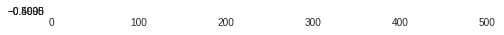

In [11]:
# Load Background Image
background_image = maps[ 0 ][ k_background ]
print( background_image.dtype )
plt.imshow( background_image[ 512:768, 0:512 ] )

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


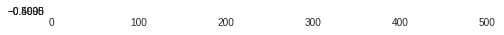

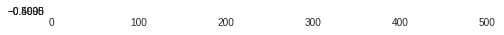

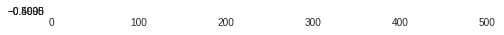

In [12]:
def blit( image, background, position=( 0, 0 ) ):
    tl = ( position[ 0 ], position[ 1 ] )
    br = ( 
        min( position[ 0 ] + image.shape[ 0 ], background.shape[ 0 ] ), 
        min( position[ 1 ] + image.shape[ 1 ], background.shape[ 1 ] )
    )

    image_resize = np.array( br ) - np.array( tl )
    image = image[ :image_resize[ 0 ], :image_resize[ 1 ], : ]

    background = background.copy()
    mask = image[ :, :, 3 ] == 255
    background[ tl[ 0 ] : br[ 0 ], tl[ 1 ] : br[ 1 ] ][ mask ] = np.zeros( ( background.shape[ -1 ] ) )

    image = image.copy()
    image[ image[ :, :, 3 ] == 0 ] = np.zeros( ( 4 ) )
    background[ tl[ 0 ] : br[ 0 ], tl[ 1 ] : br[ 1 ] ] += image[ :, :, :background.shape[ -1 ] ]
    
    return background

def backgroundOffset( background, roll=( 0, 0 ), offset=( 0, 0 ), size=( 256, 512 ) ):
  
    background = background[ offset[ 0 ] : offset[ 0 ] + size[ 0 ], offset[ 1 ] : offset[ 1 ] + size[ 1 ], : ]

    background = np.roll( background, roll[ 0 ], axis=0 )
    background = np.roll( background, roll[ 1 ], axis=1 )

    return background

test_background_image = backgroundOffset( background_image, roll=( -30, 0 ), offset=( 512, 0 ) )

plt.imshow( test_background_image )
plt.subplots()
blitted = blit( chunks[ 49, :, :, 0:4 ], test_background_image )
plt.imshow( blitted )
plt.subplots()
blitted = blit( chunks[ 49, :, :, 0:4 ], test_background_image, ( 0, 300 ) )
blitted = blit( chunks[ 49, :, :, 0:4 ], blitted, ( 0, 256 ) )
plt.imshow( blitted )

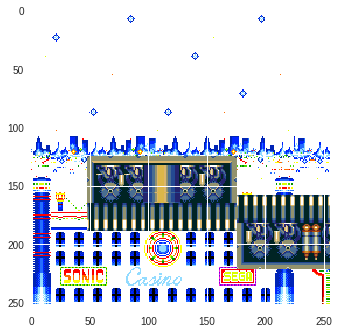

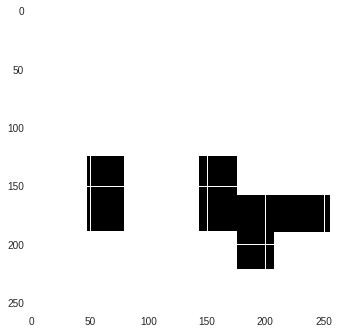

In [30]:
def rgb2gray( rgb ):
    return np.dot( rgb[ ...,:3 ], [ 0.299, 0.587, 0.114 ] )

def generateRandomImage( _chunks, background, size=( 256, 256 ) ):

    chunk_shape = _chunks.shape[ 1:3 ]
    chunk_count = int( size[ 1 ] / chunk_shape[ 1 ] )
    
    oversize = np.array( ( size[ 0 ], size[ 1 ] + chunk_shape[ 1 ] ) )

    new_image_size = np.array( [ 3, 0, 0 ] )
    new_image_size[ 1: ] = oversize
    new_image_oversize = np.zeros( new_image_size, dtype=np.uint8 )


    random_background_roll = ( -1 * np.random.randint( 30 ), 0 )
    
    random_background_offset = [ 0, 0 ]

    if( background.shape[ 0 ] - oversize[ 0 ] > 0 ):
        random_background_offset[ 0 ] = np.random.randint( background.shape[ 0 ] - oversize[ 0 ] )

    if( background.shape[ 1 ] - oversize[ 1 ] > 0 ):
        random_background_offset[ 1 ] = np.random.randint( background.shape[ 1 ] - oversize[ 1 ] )        
    
    background = backgroundOffset( 
        background, 
        roll=random_background_roll, 
        offset=random_background_offset, 
        size=oversize 
    )

    collision = np.zeros( oversize, dtype=np.uint8 )

    new_chunk_idxs = [ np.random.randint( _chunks.shape[ 0 ] ) for i in range( chunk_count + 1 ) ]

    for i, idx in enumerate( new_chunk_idxs ):
        current_chunk = _chunks[ idx ]
                                 
        image_start = ( i ) * chunk_shape[ 1 ]

        max_y_pos = size[ 0 ] - chunk_shape[ 0 ]
        y_pos = 0
        if max_y_pos > 0:
            y_pos = np.random.randint( max_y_pos )

        background = blit( current_chunk[ :, :, 0:4 ], background, ( y_pos, image_start ) )

        chunk_shape = current_chunk.shape
        col_mask = current_chunk[ :, :, 4 ] == 255
        collision[ y_pos : y_pos + chunk_shape[ 0 ], image_start : image_start + chunk_shape[ 1 ] ][ col_mask ] = 255


    random_chunk_offset = np.random.randint( oversize[ 1 ] - size[ 1 ] )

    background = background[ :, random_chunk_offset : random_chunk_offset + size[ 1 ], 0:3 ].astype( np.uint8 )
    collision = collision[ :, random_chunk_offset : random_chunk_offset + size[ 1 ] ].astype( np.uint8 )

    return [ background, collision ]

random_image = generateRandomImage( chunks, background_image, ( 256, 256 ) )

plt.imshow( random_image[ 0 ] )
plt.subplots()
plt.imshow( random_image[ 1 ] )

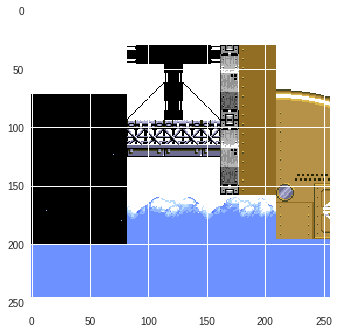

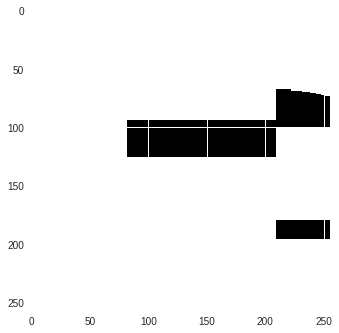

In [37]:
def generateForMapIdx( map_idx ):
    random_map = maps[ map_idx ]
    random_chunks = random_map[ k_chunks ]
    random_background = random_map[ k_background ]

    gen_x, gen_y = generateRandomImage( random_chunks, random_background )
    return ( gen_x.astype( np.float32 ) / 255 ), ( gen_y.astype( np.float32 ) / 255 )

def generateDataset( size=1000, shape=( 256, 256 ) ):    
    dw_dataset_x = np.zeros( ( size, ) + shape + (3, ) )
    dw_dataset_y = np.zeros( ( size, ) + shape )

    for i in range( size ):
        random_map_idx = np.random.randint( len( maps ) )
        gen_x, gen_y = generateForMapIdx( random_map_idx )
        dw_dataset_x[ i ] = gen_x
        dw_dataset_y[ i ] = gen_y

    return dw_dataset_x, dw_dataset_y

test_x, test_y = generateDataset( 1 )

plt.imshow( test_x[ 0 ] )
plt.subplots()
plt.imshow( test_y[ 0 ] )

## Create and train Keras model

In [0]:
x = input_layer = layers.Input( ( None, None, 3 ) )

Activations = Enum( 'Activations', 'relu leaky elu sigmoid' )

def relu():
    return layers.Activation( 'relu' )
def leaky():
    return layers.LeakyReLU( 0.3 )
def elu():
    return layers.ELU()
def sigmoid():
    return layers.Activation( 'sigmoid' )

activation_map = {
    Activations.relu: relu,
    Activations.leaky: leaky,
    Activations.elu: elu,
    Activations.sigmoid: sigmoid
}

DEFAULT_ACTIVATION = Activations.leaky
DEFAULT_NORMALIZE = True

def activationLayer( enum_value ):
    return activation_map[ enum_value ]()

def layersStraight( x, filters, normalize=DEFAULT_NORMALIZE, activation=DEFAULT_ACTIVATION ):
    x = layers.Conv2D(
        filters=filters,
        kernel_size=( 3, 3 ),
        strides=( 1, 1 ),
        padding='same'
    )( x )

    if normalize:
        x = layers.BatchNormalization( axis=-1 )( x )

    x = activationLayer( activation )( x )
        
    return x

def layersDown( x, name, filters, normalize=DEFAULT_NORMALIZE, activation=DEFAULT_ACTIVATION ):
    strides = ( 2, 2 )
    conv_layer = x = layers.Conv2D(
        filters=filters,
        kernel_size=( 3, 3 ),
        strides=strides,
        padding='same',
        name=name
    )( x )
    
    if normalize:
        x = layers.BatchNormalization( axis=-1 )( x )

    x = activationLayer( activation )( x )

    return x, conv_layer

def layersUp( x, down_conv, name, filters, normalize=DEFAULT_NORMALIZE, dropout=False, activation=DEFAULT_ACTIVATION ):
    x = layers.UpSampling2D( ( 2, 2 ) )( x )
    x = layers.Conv2D(
        filters=filters,
        padding='same',
        name=name,
        kernel_size=( 3, 3 )
    )( x )

    if normalize:
        x = layers.BatchNormalization( axis=-1 )( x )
    if dropout:
        x = layers.Dropout( 0.3 )( x )

    x = layers.Concatenate( axis=-1 )( [ x, down_conv ] )

    x = activationLayer( activation )( x )

    return x

x        = layersStraight( x, 8, normalize=False )
x, conv1 = layersDown( x, 'down_conv1', 8 )
x        = layersStraight( x, 16, normalize=False )
x, conv2 = layersDown( x, 'down_conv2', 16 )
x        = layersStraight( x, 32, normalize=False )
x, conv3 = layersDown( x, 'down_conv3', 32 )

x, _     = layersDown( x, 'middle_conv', 64 )

x        = layersStraight( x, 32, normalize=False )
x        = layersUp( x, conv3, 'up_conv3', 32, dropout=True )
x        = layersStraight( x, 16, normalize=False )
x        = layersUp( x, conv2, 'up_conv2', 16, dropout=True )
x        = layersStraight( x, 8, normalize=False )
x        = layersUp( x, conv1, 'up_conv1', 8, dropout=False )

x = layers.UpSampling2D( ( 2, 2 ) )( x )
x = layers.Conv2D(
    filters=1,
    kernel_size=( 3, 3 ), 
    padding='same'
)( x )
activationLayer( Activations.sigmoid )( x )

model = Model( inputs=[ input_layer ], outputs=[ x ] )

loss = [ losses.binary_crossentropy ]
loss_weights = [ 1 ]
optimizer = optimizers.Adam( lr=1E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08 )

model.compile( loss=loss, loss_weights=loss_weights, optimizer=optimizer )

# Uncomment to see model
# utils.plot_model( model, to_file='model.png' )
# plt.imshow( plt.imread( 'model.png' ) )
# upload( 'model.png', 'model.png' )

In [0]:
def dataGenerator():
    """
    Generate a random batch via a generator. This allows
    us to use way less memory (Colab is pretty finicky about ram ussage)
    """
    while True:
        x, y = generateDataset( 32 )
        yield x[ ... ], y[ ..., None ]

In [51]:
history = model.fit_generator(
    dataGenerator(),
    epochs = 2,
    samples_per_epoch = 1000,
    validation_data = dataGenerator(),
    validation_steps = 10,
    verbose=1,
    callbacks=[
        LosswiseKerasCallback()
    ]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=2, validation_data=<generator..., validation_steps=10, verbose=1, callbacks=[<losswise..., steps_per_epoch=1000)`
  if __name__ == '__main__':


Losswise: choosing optimal display_interval = 10 for "loss" graph.
You may override this default behavior by manually setting display_interval yourself.
Epoch 1/2
 430/1000 [===========>..................] - ETA: 2:28 - loss: 0.1791

1000/1000 [==============================] - 264s 264ms/step - loss: 0.1748 - val_loss: 0.1554
Epoch 2/2
 349/1000 [=========>....................] - ETA: 2:50 - loss: 0.1769

1000/1000 [==============================] - 265s 265ms/step - loss: 0.1755 - val_loss: 0.2841


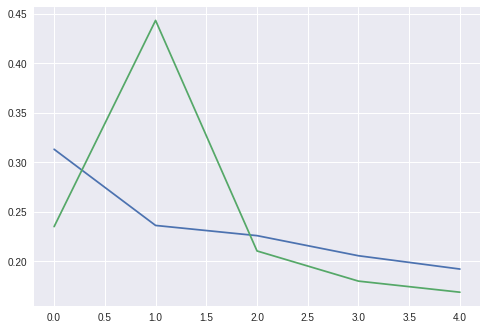

In [42]:
plt.plot( model.history.history[ 'loss' ] )
plt.plot( model.history.history[ 'val_loss' ] )

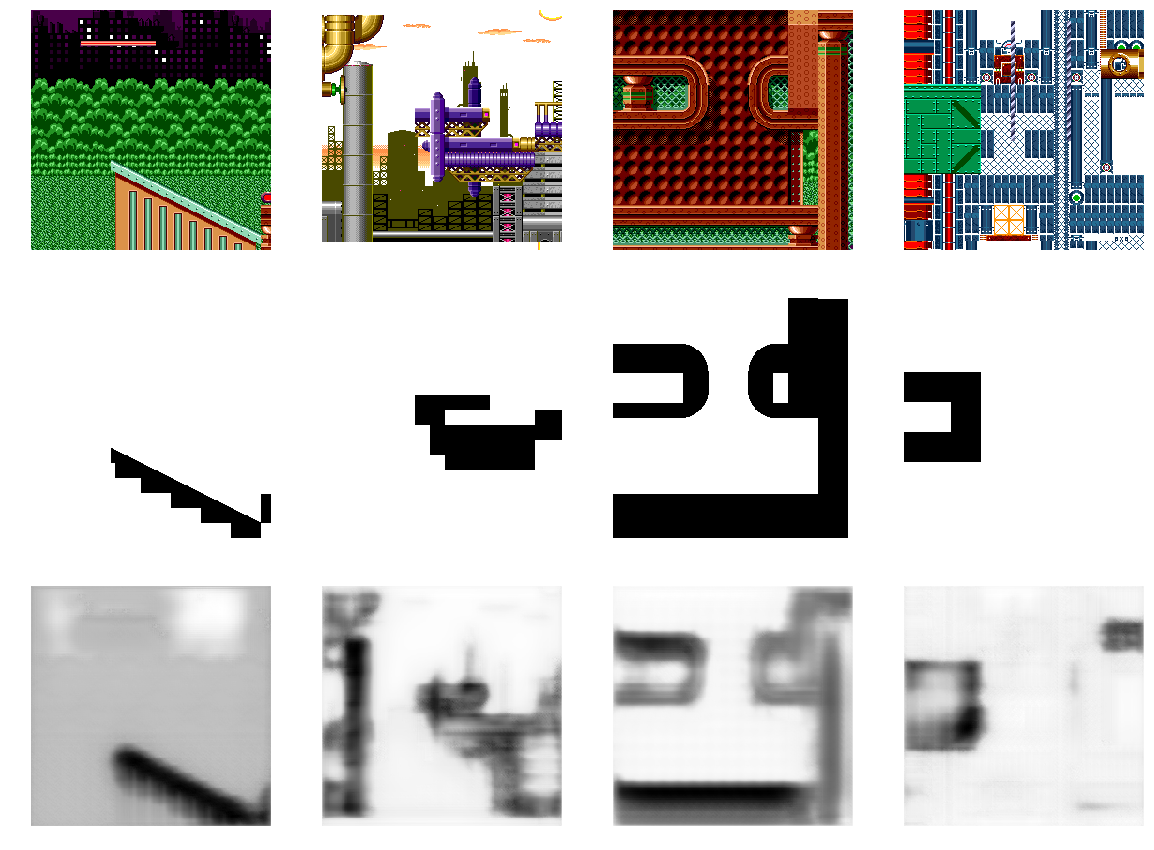

In [44]:
f = plt.figure( figsize=( 20, 15 ) )
for i in range( 0, 4 ):
    random_map = maps[ np.random.randint( len( maps ) ) ]
    random_chunks = random_map[ k_chunks ]
    random_background = random_map[ k_background ]

    gen_x, gen_y = generateDataset( 1 )

    gen_output = model.predict( gen_x )

    sp = f.add_subplot( 3, 4, i+1 )
    sp.axis( 'Off' )
    sp.imshow( gen_x[ 0 ] )
    sp = f.add_subplot( 3, 4, i+5 )
    sp.axis( 'Off' )
    sp.imshow( gen_y[ 0 ] )

    sp = f.add_subplot( 3, 4, i+9 )
    sp.axis( 'Off' )
    sp.imshow( gen_output[ 0, :, :, 0 ] )

## Save Model

Saves the model to Google Drive for easy downloading / persistence

In [47]:
!mkdir -p data/model
import time
model_filename = f'data/model-{time.strftime("%Y%m%d-%H%M%S")}.h5'
model.save( model_filename )
!ls data/

model			  model-20180525-005107.h5  roms
model-20180525-005043.h5  record		    Sonic Map Exports


In [48]:
upload( model_filename, path.split( model_filename )[ 1 ] )

Uploaded


In [49]:
model_filename

'data/model-20180525-005107.h5'

In [0]:
from google.colab import files

files.download( model_filename )